### Drag-Based Manipulation Demo

In [1]:
%load_ext autoreload
%autoreload 2

import gc
import json
import mediapy
import matplotlib.pyplot as plt
from matplotlib.patches import FancyArrowPatch
import numpy as np
from omegaconf import OmegaConf
import os
from PIL import Image
import torch

from readout_guidance import rg_helpers
from script_drag import open_points, create_frames, viz_tracks, run_ddim_inversion

**Load the Stable Diffusion Pipeline and Readout Heads**

The demo is pre-loaded to operate on real images (`configs/drag_real.yaml`), which uses the SDv1-5 appearance and correspondence heads. To switch to generated images and the SDXL readout heads, simply switch the path to `configs/drag_generated.yaml`.

In [2]:
device = "cuda"
# config_path = "configs/drag_generated.yaml"
config_path = "configs/drag_real.yaml"
config = OmegaConf.load(config_path)

In [3]:
# Load pipeline
pipeline, dtype = rg_helpers.load_pipeline(config, device)
batch_size = config["batch_size"]
latent_height = latent_width = pipeline.unet.config.sample_size
height = width = latent_height * pipeline.vae_scale_factor
image_dim = (width, height)
latent_dim = (latent_height, latent_width)

# Create edit config and load aggregation network
num_frames = config.get("num_frames", 2)
edits = rg_helpers.get_edits(config, device, dtype)

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

Not using output head
Not using output head


**Load the Drag Input**

To try other drag inputs, change the `name` and `tracks_name` according to the image and tracks you want to use. If you are using `configs/drag_generated.yaml`, you can create new names for these fields, where you will generate the image according to `prompt` and annotate the tracks in later cells.

Other example drag inputs are located in `data/drag/real`, where they are organized as follows:
```
<name>
  |_ source.png
  |_ info.json
  |_ tracks_<tracks_name>.npy
```

In [4]:
name = "wolf-looking"
tracks_name = "multi-turn"
prompt = None

In [5]:
# Set prefix to [real, generated]
drag_prefix = os.path.basename(config_path).split("_")[1].split(".")[0]
save_folder = f"data/drag/{drag_prefix}/{name}"
first_frame_path = f"{save_folder}/source.png"
if not os.path.exists(save_folder):
    os.makedirs(save_folder, exist_ok=True)
meta_exists = os.path.exists(first_frame_path) and os.path.exists(f"{save_folder}/info.json")

if drag_prefix == "real":
    assert meta_exists, "For real images make sure the source.png and info.json exist"

if meta_exists:
    first_frame = Image.open(first_frame_path)
    ann = json.load(open(f"{save_folder}/info.json"))
    seed = ann["seed"]
    prompt = ann["prompt"]
else:
    # Run generation without readout guidance
    assert prompt is not None, "Must feed prompt if metadata does not exist"
    seed = config["seed"]
    prompts, latents = rg_helpers.get_prompts_latents(
        pipeline,
        prompt,
        1, 
        seed,
        latent_dim,
        device,
        dtype,
    )
    images, results = rg_helpers.run_preset_generation(
        pipeline,
        prompts, 
        latents,
        edits=[],
        latent_dim=latent_dim,
        **config["generation_kwargs"]
    )
    first_frame = Image.fromarray(images[0])
    # Create save_info and image
    ann = {
        "seed": seed,
        "video_name": name, 
        "image_dim": image_dim, 
        "prompt": prompt
    }
    json.dump(ann, open(f"{save_folder}/info.json", "w"))
    first_frame.save(f"{save_folder}/source.png")

**Annotate Drags**

If `tracks_name` does not refer to an existing set of drags, annotate in the interface.

In [6]:
tracks_file = f"{save_folder}/tracks_{tracks_name}.npy"
tracks_exist = os.path.exists(tracks_file)

In [7]:
if tracks_exist:
    tracks = np.load(tracks_file)
else:
  %matplotlib ipympl
  user_points = []

  fig, ax = plt.subplots(1, 1)
  ax.imshow(first_frame, alpha=0.3)
  ax.axis("off")
  plt.draw()

  def mouse_event(event):
    y, x = event.ydata, event.xdata
    radius = 10
    color = "gray"
    circ = plt.Circle((x, y), radius, facecolor=color, color=color)
    ax.add_patch(circ)
    if len(user_points) % 2 == 1:
      arrow = FancyArrowPatch(user_points[-1], (x, y),
                          arrowstyle='->', color='red', mutation_scale=20, linewidth=2)
      ax.add_patch(arrow)
    user_points.append((x, y))

  fig.canvas.mpl_connect('button_press_event', mouse_event)

In [8]:
# Save tracks
if not tracks_exist:
    assert user_points and len(user_points) % 2 == 0, "Every source point must have a target point"
    user_arr = np.array(user_points)
    source_arr, target_arr = user_arr[0::2, :], user_arr[1::2, :]
    tracks = np.stack([source_arr, target_arr])[None, ...]
    np.save(tracks_file, tracks)

**Run DDIM Inversion**

For real images, seed the generation process with the noise discovered by DDIM inversion. In this setting, you cannot use classifier-free guidance (`text_guidance`=1.0 which represents sampling only from the conditional branch).

Readout Guidance Loss N/A: : 90it [00:20,  4.63it/s]

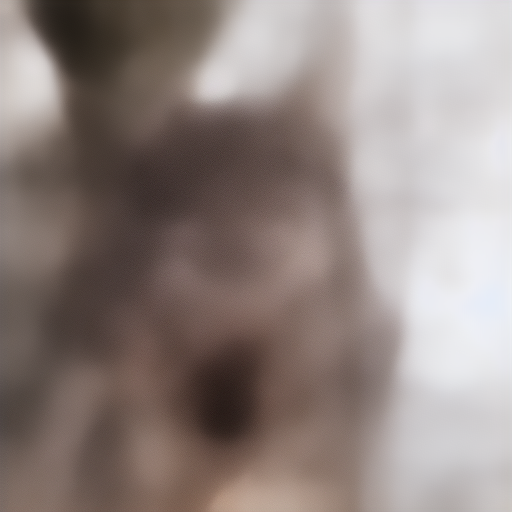

Readout Guidance Loss N/A: : 100it [00:22,  4.35it/s]


In [9]:
if "generated" in config_path:
    prompts, latents = rg_helpers.get_prompts_latents(
        pipeline,
        prompt,
        batch_size,
        seed,
        latent_dim,
        device,
        dtype,
    )
else:
    latents = run_ddim_inversion(
        config, 
        pipeline, 
        first_frame, 
        prompt,
        image_dim, 
        dtype,
        batch_size
    )
    prompts = [prompt] * batch_size

**Run Readout Guidance**

By default, the config `batch_size` is set to 2, where the left image is the result *without* readout guidance and the right image is the result *with* readout guidance. The cell will also log the readout guidance loss (if not applied, displayed as "N/A") and the predicted x0.

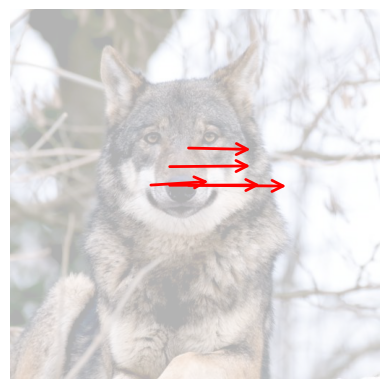

In [10]:
tracks_name, tracks, visibles, original_tracks, original_visibles = open_points(
    [tracks_file],
    ann,
    latent_dim,
    tracks_idx=0,
    interp_num=num_frames
)
tracks_frame = np.array(viz_tracks(first_frame, tracks, latent_dim).resize(image_dim))

Readout Guidance Loss N/A: : 90it [01:26,  3.35it/s]

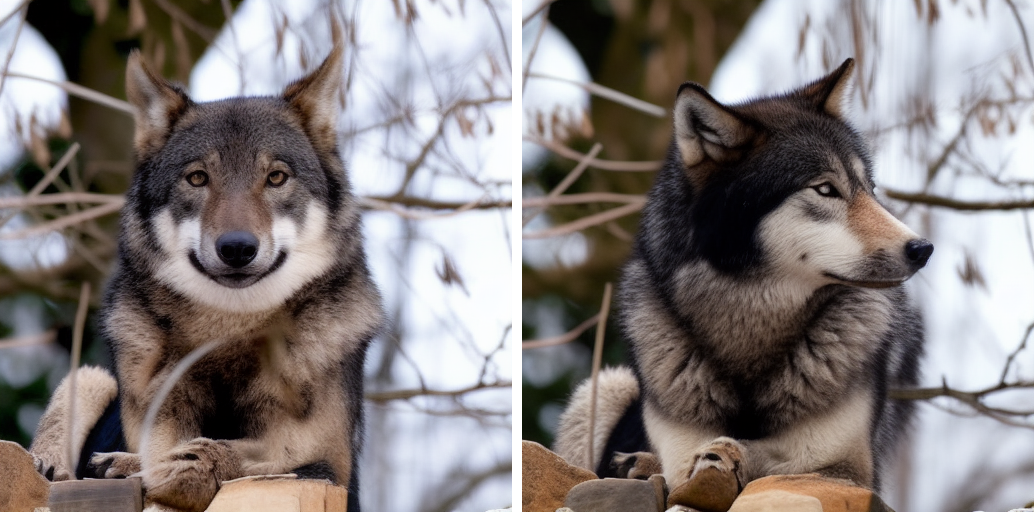

Readout Guidance Loss N/A: : 100it [01:29,  1.12it/s]


In [11]:
# Garbage collect previous generation
torch.cuda.empty_cache()
gc.collect()
# Run Readout Guidance
predicted_frames = create_frames(
    pipeline,
    prompts,
    latents,
    edits,
    latent_dim,
    config,
    tracks,
    visibles,
    num_frames,
    first_frame
)

wolf looking around




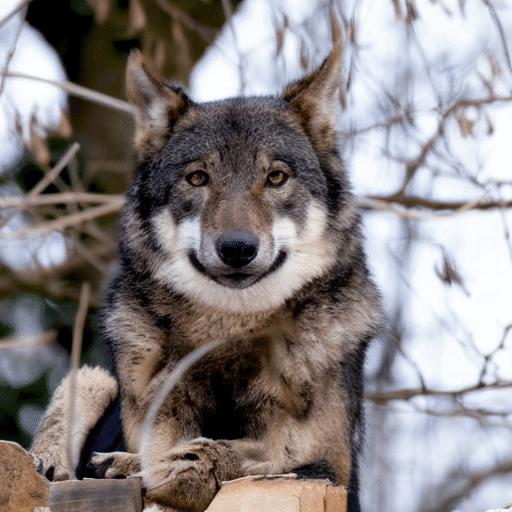

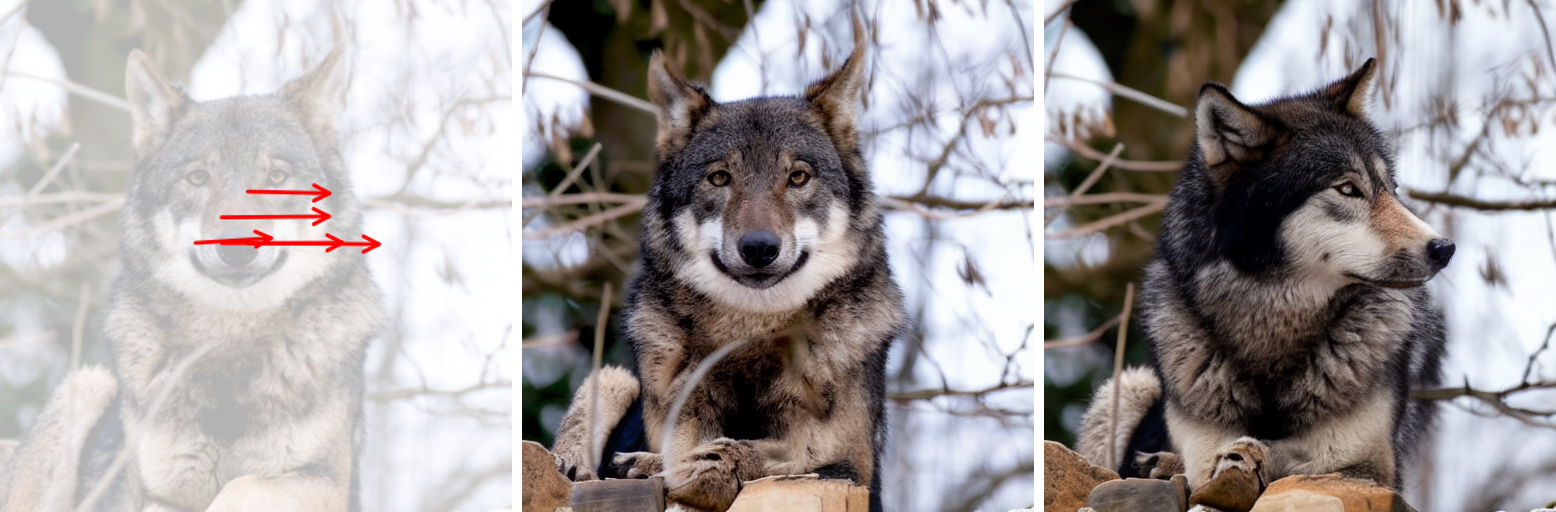

<Figure size 640x480 with 0 Axes>

In [13]:
viz_dim = (512, 512)
prompt_sep = "=" * 60
print(prompt_sep)
print(prompt)
print(prompt_sep)
print()
%matplotlib inline
plt.clf()
frames = np.stack([predicted_frames[0], tracks_frame] + predicted_frames)
video = mediapy.resize_video(frames, viz_dim)
mediapy.show_video(video, fps=config["fps"], codec="gif")
plt.clf()
display(rg_helpers.view_images(frames[1:]))